### Installation

In [ ]:
!pip install librosa soundfile numpy sklearn pyaudio

In [ ]:
!pip install pandas

In [ ]:
!pip install keras tensorflow

In [4]:
!pip install pickle-mixin

#### Imports

In [2]:
import librosa
import soundfile
import os, glob, pickle, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import pickle

#imports for cnn
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Preparing Data

Functions to add augmentation and extract Features from existing dataset

In [3]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def extract_features(data,sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally
    

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally
    

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
   

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally
    

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data,sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch,sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [4]:
X,Y=[],[]

#emotions in dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
i = 0
for file in glob.glob("E:\\Code\\Projects\\SpeechEmotionRecognition\\ser_model\\Notebooks\\Ravdess\\Actor_*\\*.wav"):
    file_name=os.path.basename(file)
    i+=1
    # Emotion From File 
    emotion=emotions[file_name.split("-")[2]]
    
    # Feature Extraction
    features = get_features(file)
    for ele in features:
        X.append(ele)
        Y.append(emotion)
print(i)

1440


In [7]:
df = pd.read_csv('ravdess.csv');
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,153,154,155,156,157,158,159,160,161,emotion
0,0,0.224306,0.664190,0.693038,0.665390,0.673116,0.696442,0.684787,0.706183,0.748844,...,6.888786e-17,6.993841e-17,7.601734e-17,7.305700e-17,6.833248e-17,7.254372e-17,7.962737e-17,7.395194e-17,7.358765e-17,neutral
1,1,0.284351,0.744315,0.799083,0.779027,0.777929,0.788401,0.707030,0.673835,0.716503,...,5.998793e-06,6.341882e-06,6.158174e-06,6.040658e-06,6.382624e-06,6.590600e-06,6.014139e-06,6.107160e-06,5.836667e-06,neutral
2,2,0.169383,0.579495,0.662042,0.674849,0.631609,0.623019,0.687452,0.671907,0.692694,...,1.885160e-15,1.743947e-15,1.590055e-15,1.477827e-15,1.528373e-15,1.689925e-15,1.679742e-15,1.602365e-15,1.500745e-15,neutral
3,3,0.196533,0.652948,0.692924,0.664361,0.648762,0.686783,0.688136,0.683010,0.735986,...,7.385022e-17,6.953341e-17,7.445123e-17,7.997667e-17,7.754530e-17,8.110750e-17,7.647289e-17,7.359221e-17,7.287654e-17,neutral
4,4,0.301604,0.760249,0.804322,0.790674,0.760021,0.781235,0.719090,0.647474,0.713795,...,3.702991e-05,3.877967e-05,3.796563e-05,3.779248e-05,3.834673e-05,3.640969e-05,3.681771e-05,3.691485e-05,3.721758e-05,neutral


In [8]:
X = df.iloc[:,:-1]
Y = df.iloc[:,-1:]

In [9]:
print(X.shape)
print(Y.shape)

(4320, 163)
(4320, 1)


In [10]:
Dataframe_x = pd.DataFrame(X)
Dataframe_y = pd.DataFrame(Y)

In [11]:
Dataframe_x.shape



(4320, 163)

In [12]:
Dataframe_y.value_counts()

emotion  
angry        576
calm         576
disgust      576
fearful      576
happy        576
sad          576
surprised    576
neutral      288
dtype: int64

In [13]:
Dataframe_x.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,152,153,154,155,156,157,158,159,160,161
0,0,0.224306,0.664190,0.693038,0.665390,0.673116,0.696442,0.684787,0.706183,0.748844,...,8.778047e-17,6.888786e-17,6.993841e-17,7.601734e-17,7.305700e-17,6.833248e-17,7.254372e-17,7.962737e-17,7.395194e-17,7.358765e-17
1,1,0.284351,0.744315,0.799083,0.779027,0.777929,0.788401,0.707030,0.673835,0.716503,...,5.747496e-06,5.998793e-06,6.341882e-06,6.158174e-06,6.040658e-06,6.382624e-06,6.590600e-06,6.014139e-06,6.107160e-06,5.836667e-06
2,2,0.169383,0.579495,0.662042,0.674849,0.631609,0.623019,0.687452,0.671907,0.692694,...,2.503228e-15,1.885160e-15,1.743947e-15,1.590055e-15,1.477827e-15,1.528373e-15,1.689925e-15,1.679742e-15,1.602365e-15,1.500745e-15
3,3,0.196533,0.652948,0.692924,0.664361,0.648762,0.686783,0.688136,0.683010,0.735986,...,8.858628e-17,7.385022e-17,6.953341e-17,7.445123e-17,7.997667e-17,7.754530e-17,8.110750e-17,7.647289e-17,7.359221e-17,7.287654e-17
4,4,0.301604,0.760249,0.804322,0.790674,0.760021,0.781235,0.719090,0.647474,0.713795,...,3.779440e-05,3.702991e-05,3.877967e-05,3.796563e-05,3.779248e-05,3.834673e-05,3.640969e-05,3.681771e-05,3.691485e-05,3.721758e-05


In [14]:
encoder = OneHotEncoder()
encoded_Y = encoder.fit_transform(np.array(Dataframe_y).reshape(-1,1)).toarray()
print(encoded_Y[:5])

[[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]


In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

In [16]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [17]:
filename = 'std_scaler.sav'
pickle.dump(scaler, open(filename, 'wb'))

## Support Vector Machine

In [18]:
from sklearn.svm  import SVC
svm_model = SVC(kernel='linear',C=1,probability=True).fit(x_train,y_train)
svm_predictions = svm_model.predict(x_test)

In [19]:
svm_predictions

array(['surprised', 'angry', 'fearful', ..., 'surprised', 'happy', 'sad'],
      dtype=object)

In [20]:
print(accuracy_score(y_true=y_test,y_pred=svm_predictions))

0.5648148148148148


In [31]:
svm_model.predict_proba(x_test)

array([[0.03021011, 0.00147292, 0.01526701, ..., 0.0023743 , 0.04823706,
        0.53872476],
       [0.19815015, 0.01444098, 0.05070459, ..., 0.01586222, 0.33890219,
        0.04125643],
       [0.16610823, 0.00058543, 0.00411638, ..., 0.00072166, 0.00670538,
        0.02287494],
       ...,
       [0.0558867 , 0.00231739, 0.22738105, ..., 0.01161237, 0.08292813,
        0.55701685],
       [0.02774213, 0.16943237, 0.06162788, ..., 0.02952297, 0.03420493,
        0.01202683],
       [0.00771679, 0.26936226, 0.00806452, ..., 0.0966821 , 0.47378331,
        0.01420971]])

0.5648148148148148


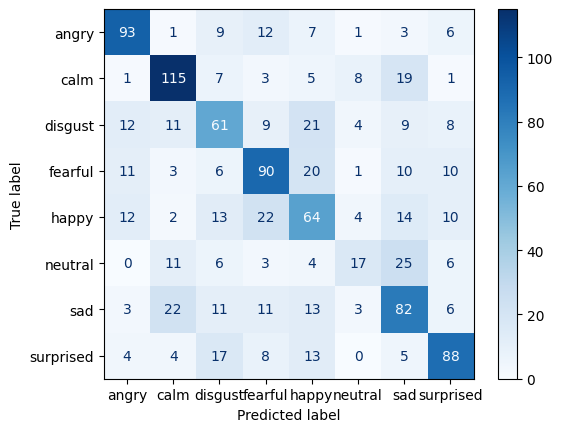

In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
confusion_matrix(y_test,svm_predictions)
ConfusionMatrixDisplay.from_predictions(y_test,svm_predictions,cmap='Blues')
print(accuracy_score(y_test,svm_predictions))
plt.savefig('test.png')

In [24]:
test_predict = svm_model.predict(x_test)
# for x in range(len(y_test)):
#     print(y_test[x] +"->"+test_predict[x])
i = 0 
for x in range(len(y_test)):
    if y_test[x] == test_predict[x]:
        i+=1
print(i)
print(len(y_test))

KeyError: 0

In [25]:
svm_model.classes_

array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad',
       'surprised'], dtype=object)

In [26]:
filename = 'svm_model.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [27]:
data, sr = librosa.load('F:\\01 Code\\01 Projects\\SpeechEmotionRecognitionApp\\ser_model\\speech-emotion-recognition-ravdess-data\\Actor_*\\*.wav')

FileNotFoundError: [Errno 2] No such file or directory: 'F:\\01 Code\\01 Projects\\SpeechEmotionRecognitionApp\\ser_model\\speech-emotion-recognition-ravdess-data\\Actor_*\\*.wav'

## Random Forest


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
  
 # create regressor object 
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0) 
  


In [29]:
# fit the regressor with x and y data 
classifier.fit(x_train, y_train)   



RandomForestClassifier(random_state=0)

In [30]:
rt_predictions = classifier.predict(x_test) 

In [31]:
print(rt_predictions)

['fearful' 'disgust' 'fearful' ... 'surprised' 'calm' 'sad']


In [32]:
classifier.predict_proba(x_test)

array([[0.12, 0.  , 0.1 , ..., 0.  , 0.06, 0.17],
       [0.12, 0.08, 0.21, ..., 0.17, 0.13, 0.1 ],
       [0.02, 0.  , 0.01, ..., 0.  , 0.04, 0.01],
       ...,
       [0.08, 0.01, 0.18, ..., 0.03, 0.07, 0.46],
       [0.08, 0.28, 0.07, ..., 0.02, 0.05, 0.17],
       [0.  , 0.23, 0.03, ..., 0.12, 0.47, 0.02]])

In [33]:
print(accuracy_score(y_true=y_test,y_pred=rt_predictions))
#print(classification_report(y_test,rt_predictions)) 
# creating a confusion matrix 
#print(confusion_matrix(y_test,rt_predictions) )



0.6935185185185185


In [34]:
filename = 'rf_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

### CNN

In [35]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 163, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 82, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 82, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [36]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 163, 1), (3240, 1), (1080, 163, 1), (1080, 1))

In [38]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50


ValueError: in user code:

    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Python310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Python310\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Python310\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Python310\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Python310\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 8) are incompatible


In [43]:
files = glob.glob("./MajorProject/cremad/AudioWAV/*")
print(files[-4:])

['./MajorProject/cremad/AudioWAV\\1091_WSI_FEA_XX.wav', './MajorProject/cremad/AudioWAV\\1091_WSI_HAP_XX.wav', './MajorProject/cremad/AudioWAV\\1091_WSI_NEU_XX.wav', './MajorProject/cremad/AudioWAV\\1091_WSI_SAD_XX.wav']


In [48]:
emotions = {
    "DIS": "disgust",
    "ANG":"angry",
    "FEA":"fearful",
    "HAP": "happy",
    "SAD":"sad"
}
X = []
Y = []
for file in files:
    key = os.path.basename(file).split('_')[2]
    if(key in emotions):
        emotion=emotions[key]
    
    # Feature Extraction
        features = get_features(file)
        for ele in features:
            X.append(ele)
            Y.append(emotion)

In [56]:
print(np.shape(X))
print(np.shape(Y))

(19065, 162)
(19065,)


In [61]:
df = pd.DataFrame(X)
df['emotion'] = Y
df.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,emotion
0,0.083837,0.677546,0.700793,0.678332,0.680873,0.679725,0.584708,0.583747,0.652854,0.656525,...,6.626328e-08,6.204719e-08,5.876392e-08,5.609468e-08,5.394531e-08,5.227852e-08,5.099203e-08,5.010445e-08,4.954257e-08,angry
1,0.244281,0.773489,0.732620,0.758074,0.772253,0.823692,0.693499,0.622440,0.680270,0.680730,...,2.022129e-03,2.130130e-03,2.058576e-03,2.146504e-03,2.166799e-03,2.146205e-03,2.089883e-03,2.000112e-03,2.135321e-03,angry
2,0.091711,0.659439,0.620962,0.630467,0.676151,0.724627,0.611476,0.552105,0.626552,0.630631,...,6.375256e-08,5.868657e-08,5.494054e-08,5.213360e-08,4.897915e-08,4.116958e-08,2.717842e-08,1.526914e-08,1.062208e-08,angry
3,0.077155,0.723378,0.734000,0.657600,0.669668,0.691899,0.606737,0.581587,0.622560,0.685837,...,4.660350e-07,4.323460e-07,4.062581e-07,3.852635e-07,3.684870e-07,3.555281e-07,3.455847e-07,3.387377e-07,3.344437e-07,disgust
4,0.124147,0.777685,0.769432,0.724776,0.757672,0.753569,0.643868,0.613844,0.668079,0.717680,...,1.704459e-04,1.548279e-04,1.622382e-04,1.584472e-04,1.622687e-04,1.540080e-04,1.510473e-04,1.606965e-04,1.602202e-04,disgust


In [62]:
df.to_csv('crema.csv')